In [287]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import timedelta
from tqdm import tqdm

### 데이터 불러오기

In [288]:
data = pd.read_csv("data/0mA(29s)_30mA(1s)_(normal).csv") #통합 데이터
data.describe()

,Voltage(V),Current(A),Resistance(Ohm),Power(W)
count,833772.000000,833772.000000,833772.000000,833772.000000
mean,3.613065,0.000857,4.328396,0.003030
std,0.014142,0.004879,101.781528,0.017255
min,3.502600,-0.003300,0.000000,0.000000
25%,3.614500,0.000000,0.000000,0.000000
50%,3.616800,0.000000,0.000000,0.000000
75%,3.618200,0.000000,0.000000,0.000000
max,3.620500,0.033900,68474.227000,0.119000


### 데이터 자르기 (time, volt, current)

In [289]:
data = data.iloc[:, :3] #.values

### 시간을 timedelt로 변경하기 위함

In [290]:
date_=[] #replace korean to english

for i in data['Time'].values:
    i = i.replace("오전", "AM")
    i = i.replace("오후", "PM")
    date_.append(i)

In [291]:
date__=[] #split blank

for i in date_:
    date__.append(i.split(" "))

In [292]:
date___=[] #switch index

for i in date__:
    tmp = i[1]
    i[1] = i[2]
    i[2] = tmp
    date___.append(i)

In [293]:
parsing_date=[]

for i in tqdm(date___):
    #print('parsing: ', i, "=", (" ").join(i))
    dt = parse((" ").join(i)) #list to string
    #print(dt)
    #print()
    parsing_date.append(dt)

100%|███████████████████████████████████████████████████████████████████████| 833772/833772 [01:19<00:00, 10466.77it/s]


### 기준 전압 인덱스 구하기

#### 통신 전류 기준을 잡는 것도 중요할 것 같음
- 문제: 통신 전류는 0이 아닌 0.010, 0.009 등도 포함하지 않으면 갑자기 전압 사용량이 적어지는 것 같은 현상이 발생

In [333]:
comm_A = np.where(data['Current(A)'] > 0.010) #통신 전류

In [349]:
# 전압이 2V 이하인 통신 전류 데이터 인덱스가 있는 경우
if np.where(data['Voltage(V)'] < 2.000):
    comm_V_ = np.where(data['Voltage(V)'] < 2.000) #2v가 넘는 곳의 인덱스
    comm_V = np.array(comm_V_).reshape(len(comm_V_[0]))
    comm_ = comm_A

    for i in comm_V:
        comm_ = np.delete(comm_, np.where(comm_ == i))
        
    comm_ = np.array(comm_[0])
    comm = np.array(comm_[0])

# 전압이 2V 이하인 통신 전류 데이터 인덱스가 없는 경우
else:
    comm_ = np.array(comm_A[0]) #comm_A[0]의 type이 tuple이기 때문에
    comm = np.array(comm_[0])

#### 통신 전류 시작 인덱스 하나만

In [351]:
for idx in range(comm_.shape[0]-1):
#     print(type(comm_))
#     print("index", idx, "i", comm_[idx])
#     print("index+1", idx+1, "i", comm_[idx+1])
#     print(comm)
    if comm_[idx]+1 != comm_[idx+1]:
        comm = np.append(comm, comm_[idx+1])


In [352]:
comm

array([     8,    129,    258, ..., 833526, 833633, 833743], dtype=int64)

#### 기준 전압은 통신 시작 전류 인덱스 바로 전

In [357]:
t_crit = comm - 1

In [358]:
t_crit

array([     7,    128,    257, ..., 833525, 833632, 833742], dtype=int64)

### 전압 회복 시간, 회복률, 전압을 확인하기 위함
- recovery_time [[통신 전, crit_time]]
- recovery_rate [[통신 중(최대), crit_rate]]
- recovery_volt [[통신 전, 통신 중(최소), crit_volt]]
- crit = 기준 전압 회복률
- 회복률이 crit 이하가 되거나 0이 아니면 다음 통신 데이터로
    - 기준 전압과 통신 전압이 같은 부분이 있어 이상한 데이터가 그려짐 (회복률이 0이 아니면)
- np.delete()하는 이유는 처음에 np.zeros(())로 만들었기 때문에 제일 처음에 0 값이 들어가 있음
    - np.empty(())를 사용하면 쓰레기 값이 들어가 있음 (어차피 같음)

In [359]:
ref = np.array([], dtype=int)

for t in tqdm(t_crit):
    tmp = t  #tmp는 >0.020 이전의 전압 인덱스
    
    for i in range(1, 5): #4번 loop
        #전압(+): t < t-1
        if (data['Voltage(V)'][tmp] < data['Voltage(V)'][t-i]):
            #t-1 > t-2 => 인덱스 변경: t-i
            if data['Voltage(V)'][t-i] >= data['Voltage(V)'][t-i-1]: #이전 이전의 전압이 더 작으면
                tmp = t-i
                break
            else:
                tmp = t- i
        #전압 (-), 전류 (+) => 인덱스 변경: t-i
        elif (data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]) and (data['Current(A)'][tmp] < data['Current(A)'][t-i]) and (data['Current(A)'][tmp] != 0.0000) and (data['Current(A)'][t-i] > 0.020):
            tmp = t-i
        #전압(-) => 인덱스 유지
        elif data['Voltage(V)'][tmp] > data['Voltage(V)'][t-i]:
            break
        #전압이 같음: t == t-1
        elif data['Voltage(V)'][tmp] == data['Voltage(V)'][t-i]:
            #t-1 < t-2 => 인덱스 변경: t-i-1
            if data['Voltage(V)'][t-i] < data['Voltage(V)'][t-i-1]:
                tmp = t-i-1
                break
            
    ref = np.append(ref, tmp)
            
ref = np.unique(ref) #중복 값 제거

100%|██████████████████████████████████████████████████████████████████████████| 14361/14361 [00:03<00:00, 4531.44it/s]


In [368]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2), dtype=int) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3), dtype=int) #통신전, 통신(최소), 회복
# index = np.zeros((1,3), dtype=int)

crit = 0.50

for _, i in enumerate(tqdm(ref)): #기준 전압
    r = np.array([]) #max을 구하기 위해서 rate값을 넣을 배열을 생성
    v = np.array([]) #min을 구하기 위해서 volt값을 넣을 배열을 생성
    
    for j in range(1, int(len(data['Voltage(V)']))):
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j]) * 100 #(기준전압 - 현재전압)*100
        r = np.append(r, np.array([rate])) #배열에 위에서 구한 전압 변화율 추가
        v = np.append(v, np.array([data['Voltage(V)'][i+j]])) #배열에 현재 전압값 추가

        #회복 전압이면 반복을 멈추고 각 배열에 요소 추가
        # 1. 현재 전압 < 다음 전압 && 2. 다음 전류가 0.020보다 작을 때 && 3. 현재 전압 변화율 <= 기준 전압 변화율 && 4. 전압 변화율 != 0
        if (data['Voltage(V)'][i+j] < data['Voltage(V)'][i+j+1]) and (data['Current(A)'][i+j+1] < 0.020) and (rate <= crit) and (rate != 0.0000):
            #전압 변화율 추가(최대 전압 변화율(최저 전압), 현재 전압 변화율)
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            #전압 회복 시간(기준 전압 시간, 회복 전압 시간)
            recovery_time = np.append(recovery_time, np.array([parsing_date[i], parsing_date[i+j]]).reshape(1,2), axis=0)
            #전압(기준 전압, 최저 전압, 회복 전압)
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j]]).reshape(1,3), axis=0)

            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)

100%|████████████████████████████████████████████████████████████████████████████| 7181/7181 [00:04<00:00, 1618.41it/s]


In [364]:
recovery_time=np.zeros((1,2)) #시간은 통신 전, 회복(crit) 시간
recovery_rate=np.zeros((1,2)) #통신(최대), crit(0.5 or smaller)
recovery_volt=np.zeros((1,3)) #통신전, 통신(최소), 회복

crit = 0.50

for _, i in enumerate(tqdm(criterion)): #기준 전압
    r = np.array([])
    v = np.array([])
    
    for j in range(int(len(data['Voltage(V)']))):
#         print("crit", i, "current", i+j+1)
#         print("crit", data['Voltage(V)'][i], "current", data['Voltage(V)'][j+i+1])
        
        rate = (data['Voltage(V)'][i] - data['Voltage(V)'][i+j+1]) * 100 #(기준전압 - 현재전압)*100
        r = np.append(r, np.array([rate]))
        v = np.append(v, np.array([data['Voltage(V)'][i+j+1]]))
        
#         print("rate", rate)
#         print("recovery_rate", recovery_rate)
        
        if rate <= crit and rate != 0.0: #회복 전압
            recovery_rate = np.append(recovery_rate, np.array([np.max(r), rate]).reshape(1,2), axis=0)
            
            recovery_time = np.append(recovery_time, np.array([parsing_date[i], parsing_date[i+j]]).reshape(1,2), axis=0)
            
            recovery_volt = np.append(recovery_volt, np.array([data['Voltage(V)'][i], np.min(v), data['Voltage(V)'][i+j+1]]).reshape(1,3), axis=0)
            break
            
recovery_rate = np.delete(recovery_rate, 0, 0)
recovery_time = np.delete(recovery_time, 0, 0)
recovery_volt = np.delete(recovery_volt, 0, 0)

100%|██████████████████████████████████████████████████████████████████████████| 14361/14361 [00:07<00:00, 1836.34it/s]


### 그래프를 그려 변화 확인

#### 통신시에 전압을 얼마나 사용하는지 볼 수 있음

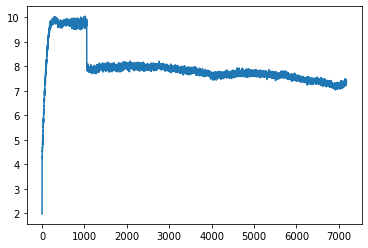

In [369]:
plt.plot(np.max(recovery_rate[:], axis=1))

In [267]:
np.max(recovery_rate[21:40], axis=1)

array([5.04, 5.33, 4.57, 5.37, 5.33, 5.56, 5.42, 5.61, 5.51, 5.72, 5.59,
       5.82, 5.67, 5.9 , 5.76, 5.98, 6.13, 6.05, 6.19])

In [268]:
recovery_time[23]

array([datetime.datetime(2021, 10, 15, 15, 44, 26),
       datetime.datetime(2021, 10, 15, 15, 44, 27)], dtype=object)

In [269]:
recovery_volt[23]

array([3.5884, 3.5427, 3.5842])

#### 시간은 timedelt형으로 되어 있기 때문에 회복 시간을 보기 위해서는 처리가 필요

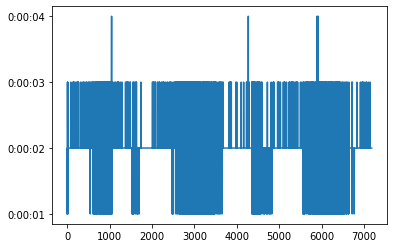

In [371]:
re_time = []

for i in recovery_time:
    re_time.append(str(i[1] - i[0]))
    
plt.plot(re_time[:])

#### 통신 전, 통신 중, 회복 전압 그래프

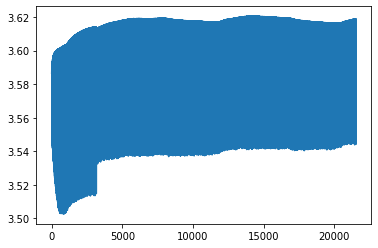

In [372]:
plt.plot(recovery_volt[:].flatten())